In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import requests

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
df = pd.read_csv(r"C:\Users\user\Downloads\seattle-weather.csv")

In [5]:
df.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [6]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df.set_index('date', inplace=True)

In [7]:
features = df[['precipitation', 'temp_max', 'temp_min', 'wind']].copy()
features.fillna(features.mean(), inplace=True)
target = df['weather']

In [8]:
df.head()

,precipitation,temp_max,temp_min,wind,weather
date,,,,,
2012-01-01,0.0,12.8,5.0,4.7,drizzle
2012-01-02,10.9,10.6,2.8,4.5,rain
2012-01-03,0.8,11.7,7.2,2.3,rain
2012-01-04,20.3,12.2,5.6,4.7,rain
2012-01-05,1.3,8.9,2.8,6.1,rain


In [34]:
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)


In [35]:
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [10]:
target_encoded = pd.get_dummies(target)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, target_encoded, test_size=0.2, random_state=42)

In [12]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [13]:
print("=== Training Features ===")
print(f"Shape: {X_train.shape}")
print(pd.DataFrame(X_train.reshape(X_train.shape[0], X_train.shape[1])).head())

=== Training Features ===
Shape: (1168, 4, 1)
          0         1         2         3
0  0.000000  0.193548  0.153543  0.582418
1  0.330948  0.416667  0.673228  0.648352
2  0.336315  0.370968  0.519685  0.197802
3  0.000000  0.223118  0.255906  0.208791
4  0.617174  0.446237  0.759843  0.263736


In [14]:
print("\n=== Training Targets (One-hot encoded) ===")
print(y_train.head())


=== Training Targets (One-hot encoded) ===
            drizzle    fog   rain   snow    sun
date                                           
2014-12-02    False   True  False  False  False
2013-09-30    False  False   True  False  False
2014-03-10    False  False   True  False  False
2013-01-15    False  False  False  False   True
2012-10-30    False  False   True  False  False


In [16]:
print("\n=== Testing Features ===")
print(f"Shape: {X_test.shape}")
print(pd.DataFrame(X_test.reshape(X_test.shape[0], X_test.shape[1])).head())


=== Testing Features ===
Shape: (293, 4, 1)
          0         1         2         3
0  0.000000  0.685484  0.716535  0.252747
1  0.103757  0.252688  0.519685  0.010989
2  0.000000  0.295699  0.452756  0.329670
3  0.000000  0.760753  0.759843  0.230769
4  0.032200  0.400538  0.562992  0.274725


In [17]:
print("\n=== Testing Targets (One-hot encoded) ===")
print(y_test.head())


=== Testing Targets (One-hot encoded) ===
            drizzle    fog   rain   snow    sun
date                                           
2014-06-11    False  False  False  False   True
2015-01-10    False  False   True  False  False
2013-02-17    False  False   True  False  False
2013-06-06    False  False  False  False   True
2014-11-02    False  False   True  False  False


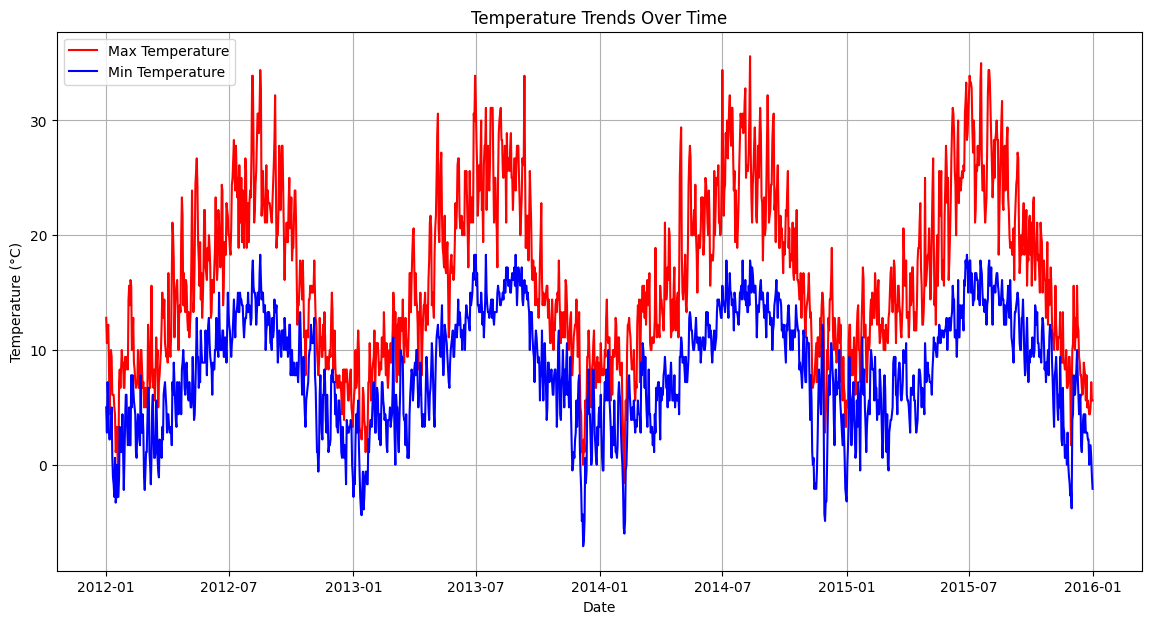

In [18]:
plt.figure(figsize=(14, 7))
plt.plot(df['temp_max'], label='Max Temperature', color='red')
plt.plot(df['temp_min'], label='Min Temperature', color='blue')
plt.title('Temperature Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid()
plt.show()

In [19]:
# LSTM Model
lstm_model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(units=y_train.shape[1], activation='softmax')
])
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
lstm_history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32,
                              validation_data=(X_test, y_test),
                              callbacks=[EarlyStopping(patience=5, min_delta=0.001)])

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.3798 - loss: 1.5486 - val_accuracy: 0.4471 - val_loss: 1.1998
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4412 - loss: 1.1348 - val_accuracy: 0.4096 - val_loss: 1.1302
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4326 - loss: 1.0855 - val_accuracy: 0.4642 - val_loss: 1.1242
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4283 - loss: 1.0840 - val_accuracy: 0.4778 - val_loss: 1.1236
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4101 - loss: 1.0729 - val_accuracy: 0.5392 - val_loss: 1.1247
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4173 - loss: 1.0855 - val_accuracy: 0.4471 - val_loss: 1.1188
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4649 - loss: 1.0851 - val_accuracy: 0.5392 - val_loss: 1.1193
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4235 - loss: 1.1088 - val_accuracy: 0.4096 - val_los

In [21]:

lstm_model.save('lstm_model.keras')

In [22]:
 #CNN-LSTM Hybrid Model
lstm_cnn_model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    Conv1D(32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(units=y_train.shape[1], activation='softmax')
])
lstm_cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [23]:
lstm_cnn_history = lstm_cnn_model.fit(X_train, y_train, epochs=50, batch_size=32,
                                      validation_data=(X_test, y_test),
                                      callbacks=[EarlyStopping(patience=5, min_delta=0.001)])


Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4451 - loss: 1.4753 - val_accuracy: 0.4471 - val_loss: 1.2379
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4540 - loss: 1.1997 - val_accuracy: 0.4471 - val_loss: 1.1018
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5250 - loss: 1.0704 - val_accuracy: 0.6382 - val_loss: 1.0875
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5299 - loss: 1.0451 - val_accuracy: 0.6485 - val_loss: 1.0708
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5729 - loss: 1.0572 - val_accuracy: 0.6109 - val_loss: 1.0517
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5815 - loss: 1.0381 - val_accuracy: 0.6519 - val_loss: 1.0269
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6521 - loss: 0.9589 - val_accuracy: 0.6621 - val_loss: 1.0018
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6518 - loss: 0.9998 - val_accuracy: 0.6792 - val_loss:

In [24]:
lstm_cnn_model.save('lstm_cnn_model.keras',include_optimizer=False)

In [25]:
# Load models and evaluate
loaded_lstm_model = load_model('lstm_model.keras')
loaded_lstm_cnn_model = load_model('lstm_cnn_model.keras')

In [26]:
print("\nLSTM Evaluation:")
print(loaded_lstm_model.evaluate(X_test, y_test))
print("\nCNN-LSTM Evaluation:")
print(loaded_lstm_cnn_model.evaluate(X_test, y_test))


LSTM Evaluation:
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8261 - loss: 0.5856  
[0.5875332355499268, 0.8259385824203491]

CNN-LSTM Evaluation:
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7969 - loss: 0.6219  
[0.6229994297027588, 0.7918089032173157]


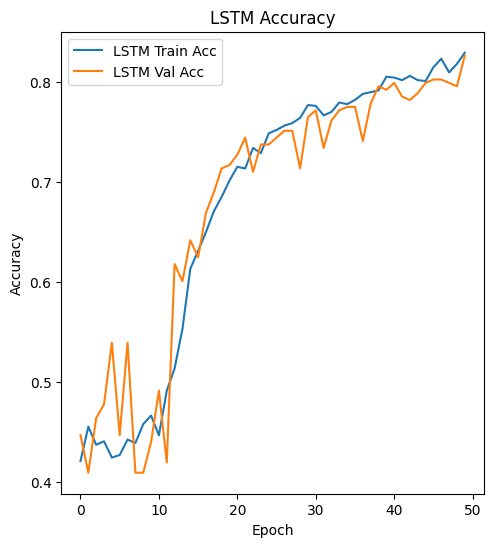

In [27]:
# Plot Accuracy & Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['accuracy'], label='LSTM Train Acc')
plt.plot(lstm_history.history['val_accuracy'], label='LSTM Val Acc')
plt.title('LSTM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

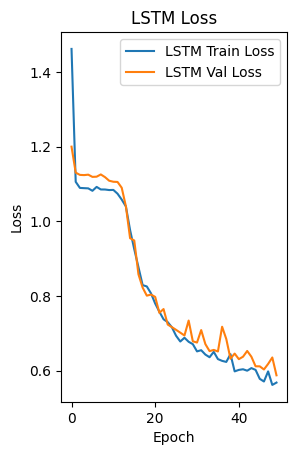

In [28]:
plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['loss'], label='LSTM Train Loss')
plt.plot(lstm_history.history['val_loss'], label='LSTM Val Loss')
plt.title('LSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [29]:
# Predictions & Report
lstm_pred_classes = np.argmax(loaded_lstm_model.predict(X_test), axis=1)
lstm_cnn_pred_classes = np.argmax(loaded_lstm_cnn_model.predict(X_test), axis=1)
y_test_classes = np.argmax(y_test.values, axis=1)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [30]:
print('\nLSTM Classification Report:')
print(classification_report(y_test_classes, lstm_pred_classes, zero_division=0))
print(confusion_matrix(y_test_classes, lstm_pred_classes))


LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.00      0.00      0.00        25
           2       0.92      0.93      0.92       120
           3       1.00      0.12      0.22         8
           4       0.76      0.99      0.86       131

    accuracy                           0.83       293
   macro avg       0.54      0.41      0.40       293
weighted avg       0.74      0.83      0.77       293

[[  0   0   0   0   9]
 [  0   0   2   0  23]
 [  0   0 111   0   9]
 [  0   0   7   1   0]
 [  0   0   1   0 130]]


In [31]:
print('\nCNN-LSTM Classification Report:')
print(classification_report(y_test_classes, lstm_cnn_pred_classes, zero_division=0))
print(confusion_matrix(y_test_classes, lstm_cnn_pred_classes))


CNN-LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.00      0.00      0.00        25
           2       0.86      0.89      0.88       120
           3       0.00      0.00      0.00         8
           4       0.74      0.95      0.83       131

    accuracy                           0.79       293
   macro avg       0.32      0.37      0.34       293
weighted avg       0.68      0.79      0.73       293

[[  0   0   2   0   7]
 [  0   0   2   0  23]
 [  0   0 107   0  13]
 [  0   0   7   0   1]
 [  0   0   6   0 125]]


In [32]:
 #Real-time weather forecast fetch & highlight function
def fetch_weather_forecast_highlight(api_key, location='Seattle', days=7):
    api_endpoint = 'http://api.weatherapi.com/v1/forecast.json'
    params = {
        'key': api_key,
        'q': location,
        'days': days,
        'aqi': 'no',
        'alerts': 'no'
    }
    # Consider 'overcast' and 'cloudy' as nice weather
    nice_conditions = ['sunny', 'rainy', 'clear', 'partly cloudy', 'overcast', 'cloudy']
    try:
        response = requests.get(api_endpoint, params=params)
        response.raise_for_status()
        data = response.json()

        print('\nReal-Time Weather Forecast (highlighting nice weather days):')
        for day in data['forecast']['forecastday']:
            date = day.get("date")
            condition = day["day"]["condition"]["text"]
            condition_lower = condition.lower()
            avg_temp_c = day["day"]["avgtemp_c"]
            total_precip_mm = day["day"]["totalprecip_mm"]

            if condition_lower in nice_conditions:
                print('*** NICE WEATHER DAY ***')
            print(f'Date: {date}')
            print(f'Weather: {condition}')
            print(f'Avg Temperature: {avg_temp_c}°C')
            print(f'Precipitation: {total_precip_mm} mm')
            if condition_lower in nice_conditions:
                print('***********************')
            print('---')

    except requests.exceptions.RequestException as e:
        print(f"Error fetching weather data: {e}")
    except KeyError as e:
        print(f"Unexpected data format in API response: missing key {e}")


In [33]:
# Example call (replace with your API key)
fetch_weather_forecast_highlight(api_key='10e86b291c2642739fe45616252505', location='Seattle', days=7)


Real-Time Weather Forecast (highlighting nice weather days):
Date: 2025-06-01
Weather: Partly Cloudy 
Avg Temperature: 13.4°C
Precipitation: 0.0 mm
---
*** NICE WEATHER DAY ***
Date: 2025-06-02
Weather: Sunny
Avg Temperature: 14.5°C
Precipitation: 0.0 mm
***********************
---
*** NICE WEATHER DAY ***
Date: 2025-06-03
Weather: Sunny
Avg Temperature: 15.4°C
Precipitation: 0.0 mm
***********************
---
Date: 2025-06-04
Weather: Overcast 
Avg Temperature: 14.1°C
Precipitation: 0.04 mm
---
*** NICE WEATHER DAY ***
Date: 2025-06-05
Weather: Sunny
Avg Temperature: 13.9°C
Precipitation: 0.0 mm
***********************
---
*** NICE WEATHER DAY ***
Date: 2025-06-06
Weather: Sunny
Avg Temperature: 17.0°C
Precipitation: 0.0 mm
***********************
---
*** NICE WEATHER DAY ***
Date: 2025-06-07
Weather: Sunny
Avg Temperature: 17.9°C
Precipitation: 0.0 mm
***********************
---
